<p align="center">
    <img src="https://github.com/GeostatsGuy/GeostatsPy/blob/master/TCG_color_logo.png?raw=true" width="220" height="240" />

</p>

## Demonstration of Lorenz Coefficient for Quantifying Spatial, Subsurface Heterogeneity

#### Alan Scherman, Rice University, UT PGE 2020 SURI

#### Supervised by:

#### Michael Pyrcz, Associate Professor, University of Texas at Austin 

##### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1) | [GeostatsPy](https://github.com/GeostatsGuy/GeostatsPy)

***
#### Introduction

This is a demonstration of how to calculate the Lorenz Coefficient of a subsurface sample from well log porosity and permeability measurements. The Lorenz Coefficient is an important heuristic imported form the sphere of macroeconomics used to quantify the spatial heterogeneity of a subsurface sample. The Lorenz Coefficient is obtained by doubling the area between the Lorenz Curve and the Homogeneous Line. It ranges from 0 to 1 where, by convention, a coefficient of less than 0.3 suggests low heterogeneity and a coefficient of more than 0.6 indicates high heterogeneity. In practical terms, a low spatial heterogeneity allows for simple displacement of subsurface fluids and a high recovery factor.
***
#### Objective

To understand and apply the methodology to calculate the Lorenz Curve and Coefficient from porosity and permeability measurements through Python functionalities.

***
#### Calculation procedure

The following list contains the necessary steps to determine the Lorenz Coefficient of a subsurface sample:

**(1)** Sort porosity ($\phi$) and permeability (**_k_**) in descending order of ratio **_k_**/$\phi$;

**(2)** Calculate storage (**_S.C._**) and flow capacity (**_F.C._**) of each layer (region between depth measurements) with:

<br>
\begin{equation}
S.C. = \phi*h
\end{equation}
\begin{equation}
F.C. = k*h
\end{equation}

where **_h_** is the layer thickness;

**(3)** Calculate the _cumulative_ storage (**_C.S.C._**) and flow capacities (**_C.F.C._**) of each layer with:

<br>
\begin{equation}
C.S.C. = \sum^{current layer}_{i = 1} \phi*h
\end{equation}
\begin{equation}
C.F.C. = \sum^{current layer}_{i = 1} k*h
\end{equation}

**(4)** Normalize the cumulative storage and flow capacities by dividing them by the largest cumulative storage and flow capacities (i.e. the last cumulative capacities calculated), respectively;

**(5)** _(Optional)_ Plot the normalized cumulative flow capacities against the normalized cumulative storage capacities (i.e. the Lorenz Curve);

**(6)** Find a curve fit for the normalized capacities in the Cartesian plane (usually a 3rd degree polynomial is sufficient);

**(7)** Integrate to find the area between the Lorenz Curve and the Homogenous Line;

**(8)** Divide the result found in **(7)** by 0.5 to obtain the Lorenz Coefficient:


\begin{equation}
LorenzCoefficient = \frac{\int^{1}_{0} (LorenzCurve - HomogeneousLine)}{0.5}
\end{equation}
***
#### Load the required libraries

The program below utilizes some standard Python packages. These should be previously installed if you have Anaconda or other similar software.

In [1]:
import pandas as pd                                                  # To import data from .xlsx or .csv file
import numpy as np                                                   # For numerical array management
from matplotlib import pyplot as plt                                 # For graphical display of Lorenz Curve

If you get a package import error, you may have to first install some of these packages. This can usually be accomplished by opening up a command window on Windows and then typing 'python -m pip install [package-name]'. More assistance is available with the respective package docs. 
***
#### Importing porosity and permeability data

The data file for this demonstration is availbale at [here](https://github.com/GeostatsGuy/GeoDataSets/blob/master/WellPorPermSample_3.xlsx). 

The well log data will be imported from an Excel (.xlsx) file. There are similar Pandas methods which allow the importation of data from .csv and other common file types. First, the Excel data is stored as a Pandas data frame. Then, the depth, porosity, and permeability data are placed into separate data frames by means of their Excel column names. Make sure that the strings match every character of the column titles in the Excel file.



In [5]:
import os
#os.chdir('C:\PGE383')
#df = pd.read_excel('WellPorPermSample_3.xlsx')                # Include file directory with os.chdir() method if necessary
df = pd.read_csv(r'https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/WellPorPermSample_3.csv')

depth = pd.DataFrame(df, columns = ['Depth (m)']); 
poros = pd.DataFrame(df, columns = ['Por (%)']); 
perme = pd.DataFrame(df, columns = ['Perm (mD)']); 

To certify that the subsurface data have been imported appropriately:

In [6]:
df.head()

,Depth (m),Por (%),Perm (mD)
0,0.25,13.0,265.5
1,0.50,13.6,116.9
2,0.75,9.0,136.9
3,1.00,17.6,216.7
4,1.25,9.4,131.6


***
#### Convert data frames to NumPy arrays

In order to facilitate data management and allow the use of helpful mathematical methods, we'll convert the Pandas data frames to NumPy arrays. Also, let's transpose the arrays to row format for conventionality.

In [7]:
depth = np.transpose(depth.to_numpy()[:,0])
poros = np.transpose(poros.to_numpy()[:,0])
perme = np.transpose(perme.to_numpy()[:,0])

Once again, let's take a look at the resulting arrays:

In [8]:
print('depth =', depth[:5], '\nporos =', poros[:5], '\nperme =', perme[:5])   # To visualize the first 5 elements of each array

depth = [0.25 0.5  0.75 1.   1.25] 
poros = [13.  13.6  9.  17.6  9.4] 
perme = [265.5 116.9 136.9 216.7 131.6]


***
#### Determine thicknesses of layers

The layer thickness is found by subtracting a shallower depth from a deeper depth. For most well logs, the layers will have a uniform thickness. However, irregular thicknesses are also possible and should be accounted for. Whichever is the case, the layer thicknesses array can be calculated in the following manner:

In [9]:
layer_thick = depth - np.concatenate(([0],depth[:-1])) 

Note that the layer_thick array should have the same dimensions as the porosity and permeability arrays.
***
#### Step (1) - Sort data in decreasing order of k/$\phi$ 

Recall that the first step to calculate the Lorenz Coefficient is to sort all layers in descending order of their ratio of permeability by porosity. Because both the porosity and permeability values are expressed as NumPy arrays, these ratios can be easily obtained by:

In [10]:
ratio = perme/poros                                                           # Equivalent to np.multiply(perme,poros)

Now, it's possible to sort the layer thickness, porosity and permeability arrays in the desired pattern:

In [11]:
layer_thick = np.flip(layer_thick[np.argsort(ratio)], axis = 0); 
poros = np.flip(poros[np.argsort(ratio)], axis = 0)
perme = np.flip(perme[np.argsort(ratio)], axis = 0)

***
#### Step (2) - Calculate storage and flow capacities

The storage and flow capacities are found by performing element-wise multiplication of the porosity and permeability arrays by the thickness array. Hence:

In [12]:
storage_cap = poros*layer_thick
flow_cap = perme*layer_thick

***
#### Step (3) - Calculate the cumulative storage and flow capacities

The next step is to compute the cumulative capacities for each layer. An easy solution to this assignment is provided by a for-loop. First, we pre-allocate the cumulative storage and flow capacities arrays. Then, we set the cumulative capacities of the first layer equal to its own capacities. Finally, we run a for-loop to compute the remaining cumlative capacities for the sequential layers.

In [13]:
cumul_storage_cap = np.zeros(len(flow_cap)+1)
cumul_flow_cap = np.zeros(len(flow_cap)+1)
    
cumul_storage_cap[1] = storage_cap[0]
cumul_flow_cap[1] = flow_cap[0]
        
for i in range(2,len(flow_cap)+1):
    cumul_storage_cap[i] = cumul_storage_cap[i-1] + storage_cap[i-1]
    cumul_flow_cap[i] = cumul_flow_cap[i-1] + flow_cap[i-1]

Note that the length of the cumulative capacities arrays are one index greater than the flow and storage capacity arrays. In fact, the first entry of both arrays is set to 0 (zero) in order to ensure convergence of the future Lorenz Curve to the origin.

***
#### Step (4) - Normalize the cumulative storage and flow capacities

To normalize the cumulative storage and flow capacities (i.e. limiting the range to [0,1]), we'll perform element-wise division of the cumulative storage and flow capacities by the sum of the all layers' storage and flow capacities, respectively. Thus, the normalized (also known as fractional) storage and flow capacities are given by:

In [14]:
frac_storage_cap = cumul_storage_cap/cumul_storage_cap[-1]
frac_flow_cap = cumul_flow_cap/cumul_flow_cap[-1]

***
#### Step (5) - Plot the Lorenz Curve

Even though we say plot the Lorenz Curve, we'll indeed plot the fractional flow capacities against the fractional storage capacities (i.e. we'll plot some of the points on the Lorenz Curve).

Let's instantiate a figure to hold our Lorenz Curve points:

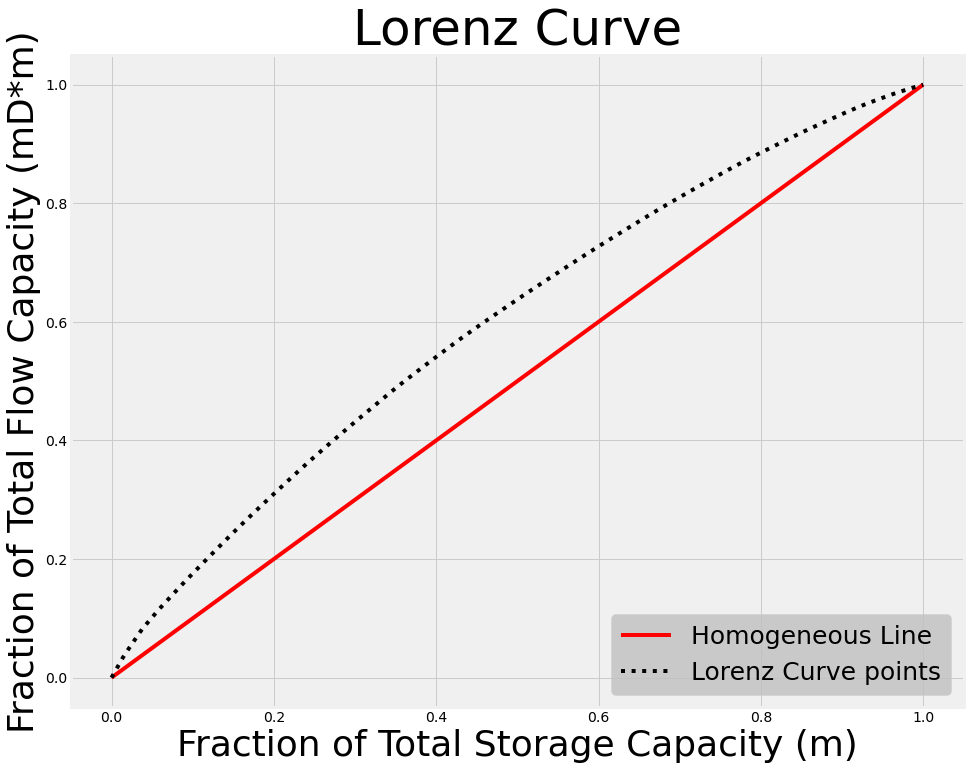

In [15]:
plt.figure(figsize = (16,12))
plt.style.use('fivethirtyeight')                                             # Just a plot style I find pretty

plt.plot([0,1], [0,1], color = 'red', label = 'Homogeneous Line')            # Homogeneous line
plt.plot(frac_storage_cap, frac_flow_cap, color = 'black', \
         label = 'Lorenz Curve points', linestyle = 'dotted')                # Sample points of Lorenz Curve

plt.title('Lorenz Curve', size = 50)
plt.xlabel('Fraction of Total Storage Capacity (m)', size = 36)
plt.ylabel('Fraction of Total Flow Capacity (mD*m)', size = 36)
plt.legend(loc = 4, facecolor = '#C0C0C0', fontsize = 25)

plt.show()

***
#### Step (6) - Find a curve fit

Now that we have some of the data points of the Lorenz Curve, we can apply a curve fit to predict the behavior of this entire subsurface sample. We'll use a 3rd degree polynomial to fit the Lorenz Curve. 

In [16]:
weights = np.ones(len(frac_storage_cap))                                     
weights[0] = 1000; weights[-1] = 1000                                           # To ensure the fit converges to (0,0) and (1,1)
    
poly_fit = np.polyfit(frac_storage_cap, frac_flow_cap, deg=3, w=weights)
print('poly_fit = ', poly_fit)

poly_fit =  [ 2.83252318e-01 -1.00166028e+00  1.71840790e+00  1.64140837e-07]


The resulting array contains the coefficients of the polynomial fit. To better visualize this polynomial in standard equation form:

In [17]:
poly_fit = np.poly1d(poly_fit)
print(poly_fit)

        3         2
0.2833 x - 1.002 x + 1.718 x + 1.641e-07


***
#### Step (7) - Integrate to find the area between the Lorenz Curve and the Homogenenous LIne

The advantage of having applied the _numpy.poly1d()_ method on Step (6) is that we now have a callable object for which we can evaluate it over any domain (here [0,1]). Then:

In [18]:
integral = np.polyint(poly_fit)
print(integral)

         4          3          2
0.07081 x - 0.3339 x + 0.8592 x + 1.641e-07 x


The result above can be easily validated since the fit has polynomial behavior. Now, we can evaluate the definite integral for the area under the Lorenz Curve and then subtract the area under the homogeneous line (i.e. area of isosceles triangle of side length 1 = 0.5):

In [19]:
lorenz_area = integral(1) - integral(0) - 0.5 
print(lorenz_area)

0.09613043353885031


Note that for practical purposes the integral(0) term could have been ignored since the integration constant is assumed to be 0.
***
#### Step (8) - Obtain the Lorenz Coefficient

The final step of this procedure is to divide the _lorenz_area_ calculated on Step (7) by 0.5, which is the total area between the lines **y = 1** and **y = x** in the domain [0,1]:

In [20]:
lorenz_coefficient = lorenz_area/0.5
print('Lorenz Coefficient = %.3f' %lorenz_coefficient)

Lorenz Coefficient = 0.192


Because the Lorenz Coefficient sits below the conventional threshold of 0.3, we can assume that the subsurface sample near the well exhibits simple displacement of fluids and a potentially high recovery factor.

Let's replicate the plot from Step (5) with shaded areas to better illustrate this Lorenz Coefficient:

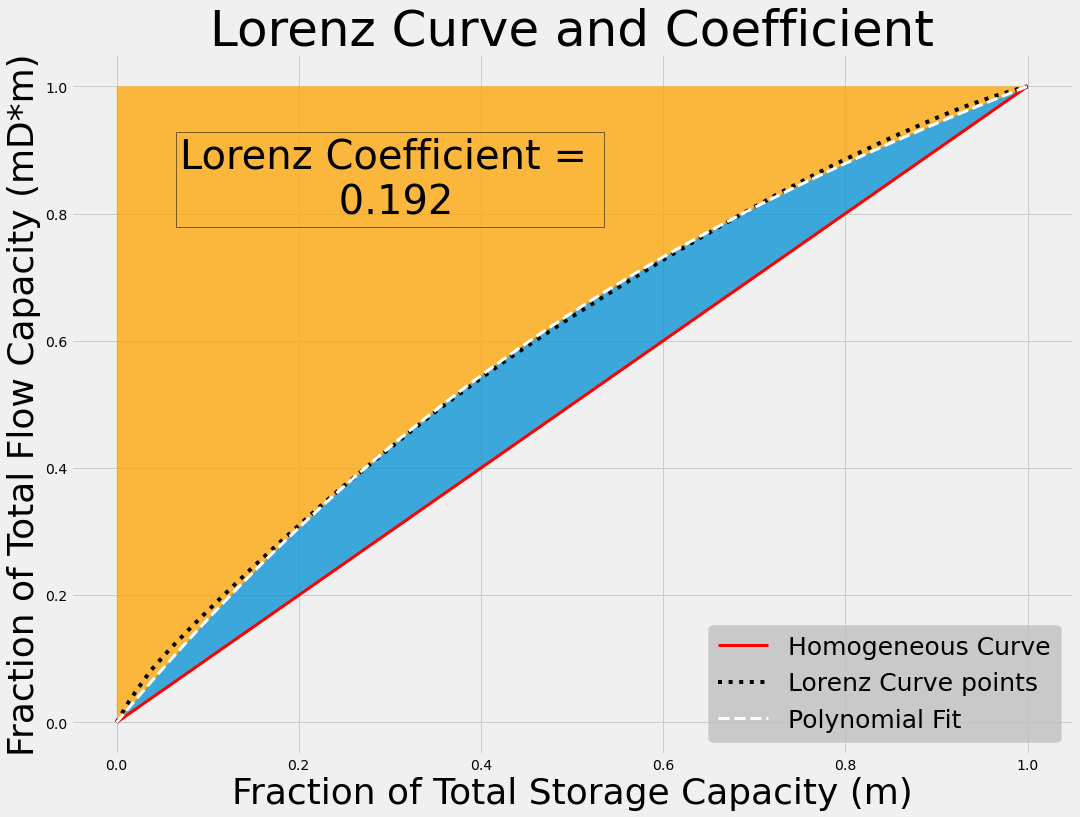

In [18]:
fig = plt.figure(figsize = (16,12))

plt.style.use('fivethirtyeight')

plt.plot([0,1],[0,1], label='Homogeneous Curve', color = 'red', linewidth = '3')                # Homogeneous line
plt.plot(frac_storage_cap, frac_flow_cap, label = 'Lorenz Curve points', \
         linestyle = 'dotted', color = 'black')
plt.plot(np.linspace(0,1,100), poly_fit(np.linspace(0,1,100)), linestyle = 'dashed',\
         linewidth = '3', label = 'Polynomial Fit', color = 'white')                            # Polynomial fit
plt.fill_between(np.linspace(0,1,100), poly_fit(np.linspace(0,1,100)),\
                 np.linspace(0,1,100), alpha = 0.75)                                            # Blue area
plt.fill_between(np.linspace(0,1,100), poly_fit(np.linspace(0,1,100)), 1,\
                 alpha = 0.75, color = 'orange')                                                # Orange area
    
plt.title('Lorenz Curve and Coefficient', size = 50)
plt.xlabel('Fraction of Total Storage Capacity (m)', size = 36)
plt.ylabel('Fraction of Total Flow Capacity (mD*m)', size = 36)
plt.legend(loc = 4, facecolor = '#C0C0C0', fontsize = 25)
plt.text(0.3, 0.8, 'Lorenz Coefficient = \n %.3f' %lorenz_coefficient, size = 40, horizontalalignment = 'center', \
         bbox=dict(facecolor='none', edgecolor='black'))

plt.show()

It's now clear that, graphically, the Lorenz Coefficient is equivalent to the blue area divided by the sum of the blue and orange areas.
***
#### Conclusion

This exercise detailed the procedure towards calculating the Lorenz Coefficient of a subsurface sample from its porosity and permeability measurements. We also covered some of the Python resources available to improve management of well data, perform the necessary mathematical transformations, and visualize the solution curve and the Lorenz Coefficient.

If you use the GeostatsPy package, the calculation and display of the Lorenz Coefficient are available through the **lorenz_curve()** and **lorenz_display()** functions. Please check the documentation on those for more detail. 


***

#### More on Michael Pyrcz and the Texas Center for Geostatistics:

### Michael Pyrcz, Associate Professor, University of Texas at Austin 
*Novel Data Analytics, Geostatistics and Machine Learning Subsurface Solutions*

With over 17 years of experience in subsurface consulting, research and development, Michael has returned to academia driven by his passion for teaching and enthusiasm for enhancing engineers' and geoscientists' impact in subsurface resource development. 

For more about Michael check out these links:

#### [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PIs including Profs. Foster, Torres-Verdin and van Oort)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Associate Professor The Hildebrand Department of Petroleum and Geosystems Engineering, Bureau of Economic Geology, The Jackson School of Geosciences, The University of Texas at Austin

#### More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

